## Load Packages

In [8]:
using DataFrames, StatsPlots, CSV, HTTP
using Distributions, Turing, MCMCChains

## Load Data

In [9]:
data = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv"
earnings  = CSV.File(HTTP.get(data).body, delim=",", missingstring="NA") |> DataFrame
first(earnings , 6)

,height,weight,male,earn,earnk,ethnicity,education,mother_education
,Int64,Int64?,Int64,Float64,Float64,String,Int64?,Int64?
1,74,210,1,50000.0,50.0,White,16,16
2,66,125,0,60000.0,60.0,White,16,16
3,64,126,0,30000.0,30.0,White,16,16
4,65,200,0,25000.0,25.0,White,17,17
5,63,110,0,50000.0,50.0,Other,16,16
6,68,165,0,62000.0,62.0,Black,18,18


In [36]:
height_weight = earnings[!,[:height, :weight]]
hw_complete= dropmissing(height_weight);
println("Entries lost: ", size(earnings)[1] - size(hw_complete)[1])

Entries lost: 27


In [10]:
println(size(earnings))
earnings_filt = dropmissing(earnings);
println(size(earnings_filt))

(1816, 15)
(1440, 15)


## Simulating uncertainty for linear predictors and predicted values

### Predict weight (in pounds) from height (in inches)

In [79]:
@model function m1(h, w)
    
    # Variance
    σ ~ truncated(Normal(0,100), 0, Inf)
    
    # Linear
    α ~ Normal(0, 500)
    β ~ Normal(0, 10)
    
    μ = α .+ h * β
    w ~ MvNormal(μ, σ)
end;

In [80]:
model = m1(hw_complete.height, hw_complete.weight)
chain1 = sample(model, NUTS(0.50), 1000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = α, β, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters        mean       std   naive_se      mcse       ess      rhat 
      Symbol     Float64   Float64    Float64   Float64   Float64   Float64 

           α   -171.9821    9.9712     0.3153    2.0017   24.4233    1.0190
           β      4.9296    0.1497     0.0047    0.0301   24.3272    1.0191
           σ     29.2319    0.4826     0.0153    0.0899   18.5949    1.0467

Quantiles
  parameters        2.5%       25.0%       50.0%       75.0%       97.5% 
      Symbol     Float64     Float64     Float64     Float64     Float64 

           α   -194.4899   -177.3650   -171.5875   -166.750

Predict weight for a 66 inch person

In [81]:
coefs_1 = get(chain1, [:α, :β, :σ])
predicted_1 = mean(coefs_1.α) + mean(coefs_1.β) * 66

println(
    string("Predicted weight for a 66-inch-tall person is ", predicted_1 |> x->round(x, digits=1), 
        " pounds with a sd of ", coefs_1.σ |> mean |> round 
        )
)

Predicted weight for a 66-inch-tall person is 153.4 pounds with a sd of 29.0


### Center Heights

In [82]:
mean(hw_complete.height)

66.59250978200112

In [83]:
MEAN_HEIGHT = 66 # following original notebook approach of explicitly writing the mean rather than calculating

hw_complete[!,"c_height"] = hw_complete.height .- MEAN_HEIGHT
model2 = model1(hw_complete.c_height, hw_complete.weight)
chain2 = sample(model2, NUTS(0.50), 1000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)

Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = α, β, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat 
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64 

           α   153.3820    0.6872     0.0217    0.0131   1359.1109    0.9992
           β     4.9541    0.1742     0.0055    0.0040   1138.6641    0.9992
           σ    29.0181    0.4725     0.0149    0.0136   1098.9807    1.0002

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

           α   152.0439   152.9182   153.3606   153.8460   154.7

### Point Prediction

In [86]:
point_pred_val = [4.0]
mpred = m1(point_pred_val, missing);
p=predict(mpred, chain2)
p["w[1]"].data |> mean |> x->round(x,digits=1)

174.4

### Posterior simulations

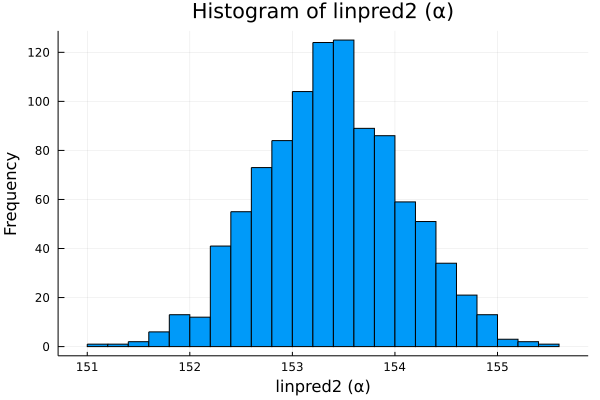

In [104]:
histogram(
    get(chain2, [:α]).α.data, 
    xlabel="linpred2 (α)",
    ylabel="Frequency",
    title="Histogram of linpred2 (α)",
    legend=false
)

### Posterior predictive simulations

variation coming from posterior uncertainty in the coefficients

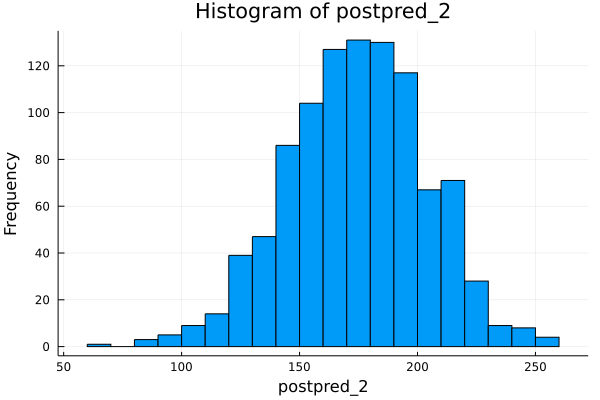

In [105]:
histogram(
    p["w[1]"].data,
    xlabel="postpred_2",
    ylabel="Frequency",
    title="Histogram of postpred_2",
    legend=false    
)

## Indicator Variables

### Predict weight (in pounds) from height (in inches)


In [106]:
println(
    string("Predicted weight for a 66-inch-tall person is ", predicted_1 |> x->round(x, digits=1), 
        " pounds with a sd of ", coefs_1.σ |> mean |> round 
        )
)

Predicted weight for a 66-inch-tall person is 153.4 pounds with a sd of 29.0


In [113]:
height_weight_male = earnings[!,[:height, :weight, :male]]
hwm_complete= dropmissing(height_weight_male);
hwm_complete[!,"c_height"] = hwm_complete.height .- MEAN_HEIGHT
println("Entries lost: ", size(earnings)[1] - size(hwm_complete)[1])

Entries lost: 27


### Include a binary variable in a regression

In [115]:
@model function m2(h,m,w)
    
    # Variance
    σ ~ truncated(Normal(0,100), 0, Inf)
    
    # Linear
    α ~ Normal(0, 500)
    βh ~ Normal(0, 10)
    βm ~ Normal(0, 10)
    
    μ = α .+ h * βh .+ m * βm
    w ~ MvNormal(μ, σ)
end;

In [119]:
model3 = m2(hwm_complete.c_height, hwm_complete.male, hwm_complete.weight)
chain3 = sample(model3, NUTS(), 1000)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\tburch\.julia\packages\AdvancedHMC\MIxdK\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)

Chains MCMC chain (1000×16×1 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = α, βh, βm, σ
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth

Summary Statistics
  parameters       mean       std   naive_se      mcse        ess      rhat 
      Symbol    Float64   Float64    Float64   Float64    Float64   Float64 

           α   149.7566    0.9487     0.0300    0.0520   461.9880    1.0018
          βh     3.9389    0.2469     0.0078    0.0105   740.3642    0.9996
          βm    11.2774    1.9020     0.0601    0.1204   491.0988    0.9999
           σ    28.7091    0.4758     0.0150    0.0163   828.2441    0.9999

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64  

In [129]:
mpred2 = m2([4], [0], missing);
p2=predict(mpred2, chain3)

Chains MCMC chain (1000×1×1 Array{Float64, 3}):

Iterations        = 1:1000
Thinning interval = 1
Chains            = 1
Samples per chain = 1000
parameters        = w[1]
internals         = 

Summary Statistics
  parameters       mean       std   naive_se      mcse         ess      rhat 
      Symbol    Float64   Float64    Float64   Float64     Float64   Float64 

        w[1]   164.6911   28.1830     0.8912    0.8750   1018.8557    1.0030

Quantiles
  parameters       2.5%      25.0%      50.0%      75.0%      97.5% 
      Symbol    Float64    Float64    Float64    Float64    Float64 

        w[1]   109.8452   146.0677   163.5305   184.4494   218.0717


In [131]:
println(
    string("Predicted weight for a 70-inch-tall female is ", p2["w[1]"].data |> mean |> round, 
        " pounds with a sd of ",  p2["w[1]"].data |> std |> round
        )
)

Predicted weight for a 70-inch-tall female is 165.0 pounds with a sd of 28.0


### Using indicator variables for multiple levels of a categorical predictor

Include ethnicity in the regression as a factor

In [ ]:
@model function m3(h,m,e,w)
    
    # Variance
    σ ~ truncated(Normal(0,100), 0, Inf)
    
    # Linear
    α ~ Normal(0, 500)
    βh ~ Normal(0, 10)
    βm ~ Normal(0, 10)
    βe ~ Normal(0, 10, )
    
    μ = α .+ h * βh .+ m * βm
    w ~ MvNormal(μ, σ)
end;

In [134]:
height_weight_male_eth = earnings[!,[:height, :weight, :male, :ethnicity]]
hwme_complete= dropmissing(height_weight_male_eth);
hwme_complete[!,"c_height"] = hwme_complete.height .- MEAN_HEIGHT
println("Entries lost: ", size(earnings)[1] - size(height_weight_male_eth)[1])

Entries lost: 0
